# Thesis Project: Text Detection for TEMPEST Screen Attack

Note that the workspace is mounting to Google Drive. All the input data should be prepared under `/content/drive/MyDrive/thesis_text_detection` before running and testing.

In [3]:
from google.colab import drive
drive.mount('/content/drive')
ws_dir = '/content/drive/MyDrive/thesis_text_detection'

Mounted at /content/drive


In [4]:
## Import Section

import torch
import numpy as np
import matplotlib.pyplot as plt
import skimage as sk
import skimage.transform as skT
import skimage.io as skio
import cv2

import itertools
import sys
import os
import glob
import tqdm
import random
import math

In [5]:
## Defining Basic Functions

def plotgray(im, cmap='gray', save_dir=None, file_name=None, axis=True):
    plt.figure()
    plt.imshow(im, cmap=cmap)
    plt.axis(axis)
    if save_dir:
        plt.savefig(os.path.join(save_dir, file_name), dpi=500)
    plt.show()

def plot3ch(im, save_dir=None, file_name=None, axis=True):
    plt.figure()
    plt.imshow(im)
    plt.axis(axis)
    if save_dir:
        plt.savefig(os.path.join(save_dir, file_name), dpi=500)
    plt.show()

def normalize_clip(im):
    return np.minimum(np.maximum(im, 0), 1)

def normalize(im):
    return (im-np.min(im))/(np.max(im)-np.min(im))

def rgb2gray(rgb):
    return rgb.dot([0.2989, 0.5870, 0.1140])

def scan_dir_sorted(dir):
    with os.scandir(dir) as entries:
        sorted_entries = sorted(entries, key=lambda entry: entry.name)
        sorted_items = [entry.name for entry in sorted_entries]
    return sorted_items

## Part 0: Text Recognition

In [6]:
## Dataloader

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        im, label = sample
        im = im.transpose((2, 0, 1)) # swap color axis to (c, h, w)
        return torch.from_numpy(im), torch.tensor(label)

class DigitDataset(Dataset):

    def __init__(self, split: str = "train", transform=None):
        assert split in ("train", "validation")
        data_range = range(50) if split == "train" else range(50, 60)
        self.images, self.labels, self.transform = [], [], transform

        input_dir = os.path.join(ws_dir, 'digit_data')
        file_path = os.path.join(input_dir, 'label.txt')
        with open(file_path) as f:
            lines = f.readlines()

        tags, start_points = [], []
        for line in lines:
            tag, x, y = line.split(',')[1:]
            tags.append(tag)
            start_points.append([int(x), int(y)])
        r, c, dx, dy, ly = 3, 17, 81, 177, 110

        sorted_items = scan_dir_sorted(input_dir)[:-1]
        progress_bar = tqdm.tqdm(data_range)
        for I in progress_bar:
            file_path = os.path.join(input_dir, sorted_items[I])
            im = sk.img_as_float(skio.imread(file_path))
            im = (rgb2gray(im)-0.5)[:, :, None]
            im = im.astype('float32')
            sx, sy = start_points[I]
            for i in range(r):
                for j in range(c):
                    im_cropped = im[sy+i*dy:sy+i*dy+ly, sx+j*dx:sx+(j+1)*dx]
                    im_cropped = skT.resize(im_cropped, (60, 40))
                    self.images.append(im_cropped)
                    self.labels.append(int(tags[I][i*c+j]))

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx: int):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.images[idx], self.labels[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

In [7]:
my_transforms = transforms.Compose([
    ToTensor()
])
train_dataset = DigitDataset(split="train", transform=my_transforms)
train_loader = DataLoader(train_dataset, batch_size=64)

test_dataset = DigitDataset(split="validation", transform=ToTensor())
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


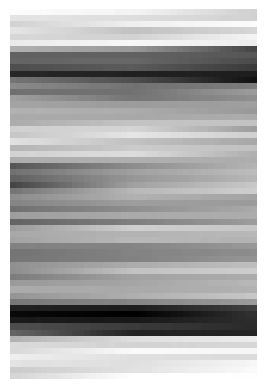

tensor(1), 

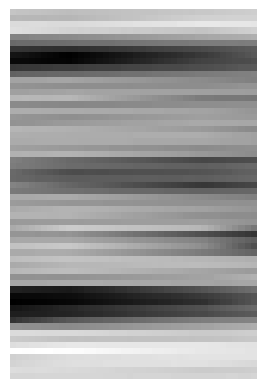

tensor(3), 

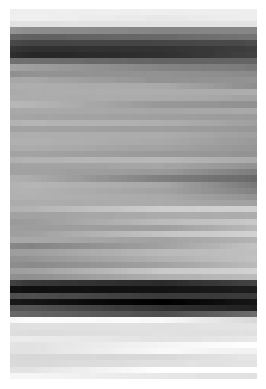

tensor(2), 

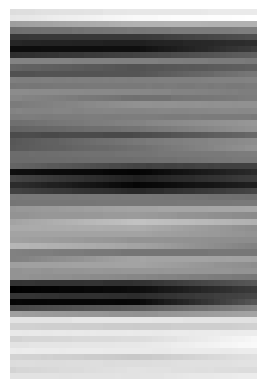

tensor(9), 

In [ ]:
output_dir = os.path.join(ws_dir, 'output/part0')
for idx, i in enumerate([215, 1246, 891, 2024]):
    plotgray(train_dataset[i][0][0], save_dir=output_dir, file_name=f'input_eg{idx}', axis=False)
    print(train_dataset[i][1], end=', ')

In [8]:
## CNN

import torch.nn as nn
import torch.nn.functional as F


class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # fully connected layers
        self.fc1 = nn.Linear(16 * 12 * 7, 120)  # 12*7 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # (28, 18)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # (12, 7)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

net = LeNet().cuda()
print(net)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1344, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
## Training

criterion = nn.CrossEntropyLoss()

num_epochs = 25
train_losses, test_losses = [], [] # loss for every epoch

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
for epoch in range(num_epochs):

    progress_bar = tqdm.tqdm(train_loader)
    running_losses = []

    for i, data in enumerate(progress_bar):
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        # forward pass
        outputs = net(inputs)
        # compute loss
        loss = criterion(outputs, labels)
        # backward pass
        loss.backward()
        # update network parameters
        optimizer.step()
        # save statistics
        running_losses.append(loss.item())
        progress_bar.set_description(f"Loss: {loss}")

    # train loss
    train_losses.append(sum(running_losses)/len(running_losses))
    # validation loss
    with torch.no_grad():
        inputs, labels = next(iter(test_loader))
        outputs = net(inputs.cuda())
        loss = criterion(outputs, labels.cuda())
        test_losses.append(loss.item())

# save the network
output_dir = os.path.join(ws_dir, 'output/part0')
torch.save(net.state_dict(), os.path.join(output_dir, 'checkpoint.pt'))

Loss: 0.0033218206372112036: 100%|██████████| 40/40 [00:00<00:00, 184.85it/s]


In [9]:
# reload the pre-saved network
output_dir = os.path.join(ws_dir, 'output/part0')
state_dict = torch.load(os.path.join(output_dir, 'checkpoint.pt'))
net.load_state_dict(state_dict)

<All keys matched successfully>

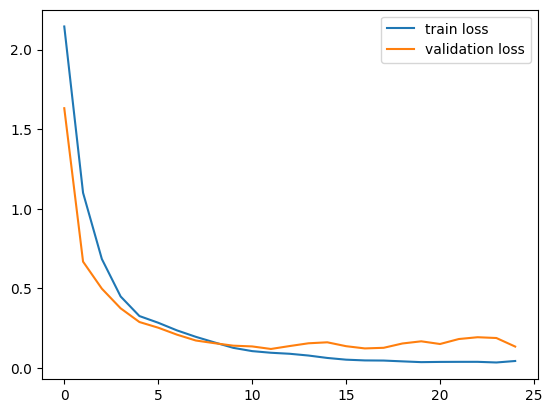

Final train loss: 0.04324471946456469, validation loss: 0.1339312046766281


In [ ]:
plt.figure()
plt.plot(np.arange(num_epochs), train_losses, label='train loss')
plt.plot(np.arange(num_epochs), test_losses, label='validation loss')
plt.legend()
plt.savefig(os.path.join(output_dir, f"loss.jpg"), dpi=500)
plt.show()
print(f"Final train loss: {train_losses[-1]}, validation loss: {test_losses[-1]}")

In [ ]:
## Testing

total, correct = 0, 0
with torch.no_grad():

    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        # calculate outputs by running images through the network
        outputs = net(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predictions = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predictions == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 96 %


### Initial Trial

Directly do grid search on the whole image using the text recognition model to identify text area.

In [10]:
## Grid Search Algorithm

class GridSearchDataset(Dataset):

    def __init__(self, image_idx: int):
        assert image_idx >= 50  # make sure it is test image
        input_dir = os.path.join(ws_dir, 'digit_data')
        sorted_items = scan_dir_sorted(input_dir)[:-1]
        file_path = os.path.join(input_dir, sorted_items[image_idx])
        im = sk.img_as_float(skio.imread(file_path))
        im = rgb2gray(im)-0.5
        self.im = im = im.astype('float32')

        h, w = self.im.shape
        self.lx, self.ly = 81, 110
        self.dx, self.dy = self.lx // 10, self.ly // 10
        sorted_x, sorted_y = np.arange(0, w-self.lx+1, self.dx), np.arange(0, h-self.ly+1, self.dy)
        self.gridshape = (len(sorted_y), len(sorted_x))
        self.sorted_x = np.tile(sorted_x[None, :], [len(sorted_y), 1]).reshape(-1)
        self.sorted_y = np.tile(sorted_y[:, None], [1, len(sorted_x)]).reshape(-1)

    def __len__(self) -> int:
        return self.sorted_x.size

    def __getitem__(self, idx: int):
        x, y = self.sorted_x[idx], self.sorted_y[idx]
        im_cropped = self.im[y:y+self.ly, x:x+self.lx]
        im_cropped = skT.resize(im_cropped, (60, 40))
        return torch.from_numpy(im_cropped[None, :, :])

gridsearch_dataset = GridSearchDataset(image_idx=50)
gridsearch_loader = DataLoader(gridsearch_dataset, batch_size=64)


100%|██████████| 454/454 [00:15<00:00, 28.94it/s]


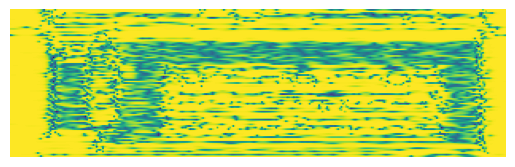

In [12]:
heatmap = np.array([])
heatmap_pred = np.array([])

with torch.no_grad():

    progress_bar = tqdm.tqdm(gridsearch_loader)
    for inputs in progress_bar:
        inputs = inputs.cuda()
        # calculate outputs by running images through the network
        logits = net(inputs)
        # calculate probabilities using logits that the network outputs
        probs = F.softmax(logits, 1)
        # the class with the highest energy is what we choose as prediction
        max_probs, predictions = torch.max(probs.data, 1)

        heatmap = np.concatenate((heatmap, max_probs.cpu().numpy()))
        heatmap_pred = np.concatenate((heatmap_pred, predictions.cpu().numpy()))

gridshape = gridsearch_dataset.gridshape
heatmap, heatmap_pred = heatmap.reshape(gridshape), heatmap_pred.reshape(gridshape)

output_dir = os.path.join(ws_dir, 'output/part0')
plotgray(heatmap, cmap='viridis', save_dir=output_dir, file_name='heatmap', axis=False)


In [ ]:
del net
del train_dataset
del test_dataset

## Part 1: Identifying Text Area

In [ ]:
## Dataloader

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        im, label = sample
        im = im.transpose((2, 0, 1)) # swap color axis to (c, h, w)
        return torch.from_numpy(im), torch.tensor(label)

class RandomShifting(object):
    """Randomly shift the image."""

    def __init__(self, translate=(0, 0)): # Note: translate = (w, h)
        self.translate = translate

    def get_random(self):
        delta_x = torch.randint(-self.translate[0], self.translate[0]+1, (1,)).item()
        delta_y = torch.randint(-self.translate[1], self.translate[1]+1, (1,)).item()
        return delta_x, delta_y

    def __call__(self, sample):
        im, label = sample
        dx, dy = self.get_random()
        return torch.roll(im, shifts=(0, dy, dx), dims=(0, 1, 2)), label

class RandomVerticalFlip(object):
    """Vertically flip the given image randomly with a given probability."""

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, sample):
        im, label = sample
        return transforms.RandomVerticalFlip(p=self.p)(im), label

class RandomHorizontalFlip(object):
    """Horizontally flip the given image randomly with a given probability."""

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, sample):
        im, label = sample
        return transforms.RandomHorizontalFlip(p=self.p)(im), label

class IsDigitDataset(Dataset):

    def __init__(self, split: str = "train", transform=None):
        assert split in ("train", "validation")
        data_range = range(50) if split == "train" else range(50, 60)
        self.images, self.labels, self.transform = [], [], transform

        input_dir = os.path.join(ws_dir, 'digit_data')
        file_path = os.path.join(input_dir, 'label.txt')
        with open(file_path) as f:
            lines = f.readlines()

        start_points = []
        for line in lines:
            _, x, y = line.split(',')[1:]
            start_points.append([int(x), int(y)])
        r, c, dx, dy, ly = 3, 17, 81, 177, 110

        sorted_items = scan_dir_sorted(input_dir)[:-1]
        progress_bar = tqdm.tqdm(data_range)
        for I in progress_bar:
            file_path = os.path.join(input_dir, sorted_items[I])
            im = sk.img_as_float(skio.imread(file_path))
            im = (rgb2gray(im)-0.5)[:, :, None]
            im = im.astype('float32')

            # load positive examples
            sx, sy = start_points[I]
            for i in range(r):
                for j in range(c):
                    im_cropped = im[sy+i*dy:sy+i*dy+ly, sx+j*dx:sx+(j+1)*dx]
                    im_cropped = skT.resize(im_cropped, (60, 40))
                    self.images.append(im_cropped)
                    self.labels.append(1)

            # load negative examples
            h, w, _ = im.shape
            for i in range(50):
                x, y = random.randint(0, sx-dx+1), random.randint(0, h-ly+1)
                im_cropped = im[y:y+ly, x:x+dx]
                im_cropped = skT.resize(im_cropped, (60, 40))
                self.images.append(im_cropped)
                self.labels.append(0)

                x, y = random.randint(0, w-dx+1), random.randint(0, sy-ly+1)
                im_cropped = im[y:y+ly, x:x+dx]
                im_cropped = skT.resize(im_cropped, (60, 40))
                self.images.append(im_cropped)
                self.labels.append(0)

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx: int):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.images[idx], self.labels[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

In [ ]:
my_transforms = transforms.Compose([
    ToTensor(),
    RandomShifting(translate=(4, 6)),
    RandomVerticalFlip(p=0.5),
    RandomHorizontalFlip(p=0.5)
])
train_dataset = IsDigitDataset(split="train", transform=my_transforms)
train_loader = DataLoader(train_dataset, batch_size=64)

test_dataset = IsDigitDataset(split="validation", transform=ToTensor())
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


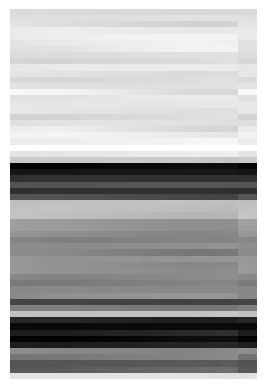

tensor(0), 

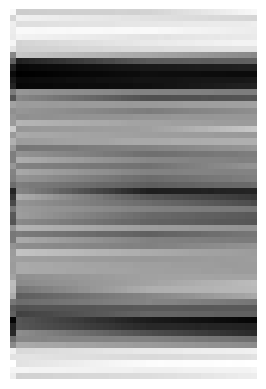

tensor(1), 

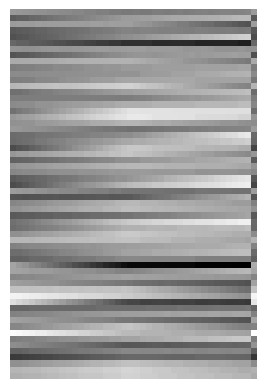

tensor(0), 

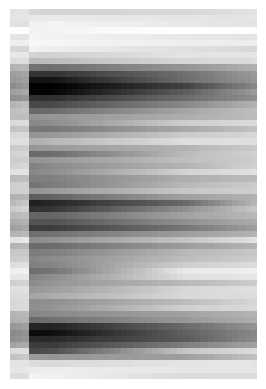

tensor(1), 

In [ ]:
output_dir = os.path.join(ws_dir, 'output/part1')
for idx, i in enumerate([215, 1250, 891, 5000]):
    plotgray(train_dataset[i][0][0], save_dir=output_dir, file_name=f'input_eg{idx}', axis=False)
    print(train_dataset[i][1], end=', ')

In [ ]:
## CNN

import torch.nn as nn
import torch.nn.functional as F


class BinaryLeNet(nn.Module):

    def __init__(self):
        super(BinaryLeNet, self).__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # fully connected layers
        self.fc1 = nn.Linear(16 * 12 * 7, 120)  # 12*7 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # (28, 18)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # (12, 7)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

net = BinaryLeNet().cuda()
print(net)

BinaryLeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1344, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


In [ ]:
## Training

criterion = nn.CrossEntropyLoss()

num_epochs = 50
train_losses, test_losses = [], [] # loss for every epoch

optimizer = torch.optim.Adam(net.parameters(), lr=2e-4)
for epoch in range(num_epochs):

    progress_bar = tqdm.tqdm(train_loader)
    running_losses = []

    for i, data in enumerate(progress_bar):
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        # forward pass
        outputs = net(inputs)
        # compute loss
        loss = criterion(outputs, labels)
        # backward pass
        loss.backward()
        # update network parameters
        optimizer.step()
        # save statistics
        running_losses.append(loss.item())
        progress_bar.set_description(f"Loss: {loss}")

    # train loss
    train_losses.append(sum(running_losses)/len(running_losses))
    # validation loss
    with torch.no_grad():
        inputs, labels = next(iter(test_loader))
        outputs = net(inputs.cuda())
        loss = criterion(outputs, labels.cuda())
        test_losses.append(loss.item())

# save the network
output_dir = os.path.join(ws_dir, 'output/part1')
torch.save(net.state_dict(), os.path.join(output_dir, 'checkpoint.pt'))

Loss: 5.700564997823676e-06: 100%|██████████| 118/118 [00:01<00:00, 70.11it/s]


In [ ]:
# reload the pre-saved network
output_dir = os.path.join(ws_dir, 'output/part1')
state_dict = torch.load(os.path.join(output_dir, 'checkpoint.pt'))
net.load_state_dict(state_dict)

<All keys matched successfully>

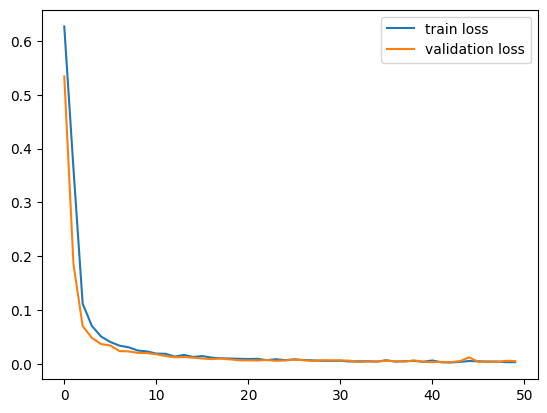

Final train loss: 0.002732607646323031, validation loss: 0.004826501477509737


In [ ]:
plt.figure()
plt.plot(np.arange(num_epochs), train_losses, label='train loss')
plt.plot(np.arange(num_epochs), test_losses, label='validation loss')
plt.legend()
plt.savefig(os.path.join(output_dir, f"loss.jpg"), dpi=500)
plt.show()
print(f"Final train loss: {train_losses[-1]}, validation loss: {test_losses[-1]}")

In [ ]:
## Testing

total, correct = 0, 0
with torch.no_grad():

    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        # calculate outputs by running images through the network
        outputs = net(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predictions = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predictions == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 99 %


In [ ]:
## Grid Search Algorithm

class GridSearchDataset(Dataset):

    def __init__(self, image_idx: int):
        assert image_idx >= 50  # make sure it is test image
        input_dir = os.path.join(ws_dir, 'digit_data')
        sorted_items = scan_dir_sorted(input_dir)[:-1]
        file_path = os.path.join(input_dir, sorted_items[image_idx])
        im = sk.img_as_float(skio.imread(file_path))
        im = rgb2gray(im)-0.5
        self.im = im = im.astype('float32')

        h, w = self.im.shape
        self.lx, self.ly = 81, 110
        self.dx, self.dy = self.lx // 10, self.ly // 10
        sorted_x, sorted_y = np.arange(0, w-self.lx+1, self.dx), np.arange(0, h-self.ly+1, self.dy)
        self.gridshape = (len(sorted_y), len(sorted_x))
        self.sorted_x = np.tile(sorted_x[None, :], [len(sorted_y), 1]).reshape(-1)
        self.sorted_y = np.tile(sorted_y[:, None], [1, len(sorted_x)]).reshape(-1)

    def __len__(self) -> int:
        return self.sorted_x.size

    def __getitem__(self, idx: int):
        x, y = self.sorted_x[idx], self.sorted_y[idx]
        im_cropped = self.im[y:y+self.ly, x:x+self.lx]
        im_cropped = skT.resize(im_cropped, (60, 40))
        return torch.from_numpy(im_cropped[None, :, :])

gridsearch_dataset = GridSearchDataset(image_idx=50)
gridsearch_loader = DataLoader(gridsearch_dataset, batch_size=64)


100%|██████████| 454/454 [00:16<00:00, 27.31it/s]


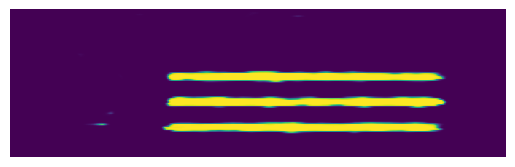

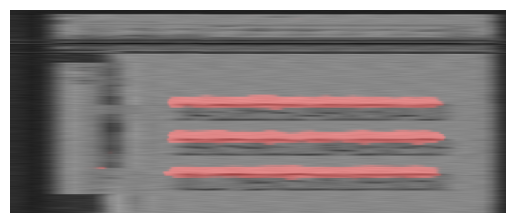

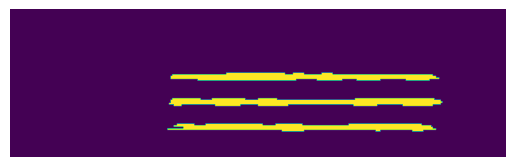

In [ ]:
heatmap = np.array([])
heatmap_pred = np.array([])

with torch.no_grad():

    progress_bar = tqdm.tqdm(gridsearch_loader)
    for inputs in progress_bar:
        inputs = inputs.cuda()
        # calculate outputs by running images through the network
        logits = net(inputs)
        # calculate probabilities using logits that the network outputs
        probs = F.softmax(logits, 1)
        # the class with the highest energy is what we choose as prediction
        _, predictions = torch.max(probs.data, 1)

        heatmap = np.concatenate((heatmap, probs[:, 1].cpu().numpy()))
        heatmap_pred = np.concatenate((heatmap_pred, predictions.cpu().numpy()))

gridshape = gridsearch_dataset.gridshape
heatmap, heatmap_pred = heatmap.reshape(gridshape), heatmap_pred.reshape(gridshape)

# plot heatmap
output_dir = os.path.join(ws_dir, 'output/part1')
plotgray(heatmap, cmap='viridis', save_dir=output_dir, file_name='heatmap', axis=False)

# plot heatmap on the original image
im = gridsearch_dataset.im
dx, dy = gridsearch_dataset.dx, gridsearch_dataset.dy
heatmap_aligned = np.ndarray((gridshape[0]*dy, gridshape[1]*dx))
for i in range(dy):
    for j in range(dx):
        heatmap_aligned[i::dy, j::dx] = heatmap

im_aligned = np.tile(im[:gridshape[0]*dy, :gridshape[1]*dx][:, :, None], (1, 1, 3)) + 0.5
heatmap_im = im_aligned * 0.65
heatmap_im[:, :, 0] += heatmap_aligned * 0.35
plot3ch(heatmap_im, save_dir=output_dir, file_name='heatmap_with_image', axis=False)

# plot heatmap thresholded
heatmap_bi = heatmap > 0.99
plotgray(heatmap_bi, cmap='viridis', save_dir=output_dir, file_name='heatmap_bi', axis=False)


In [ ]:
del net
del train_dataset
del test_dataset

## Part 2: Improved Text Recognition

In [ ]:
## Dataloader

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

def get_random_shift(translate): # Note: translate = (w, h)
        delta_x = torch.randint(-translate[0], translate[0]+1, (1,)).item()
        delta_y = torch.randint(-translate[1], translate[1]+1, (1,)).item()
        return delta_x, delta_y

def crop_image_with_extended_frame(im, x, y):
    lx, ly = 81, 110
    ex, ey = int(lx / 1.5), int(ly / 1.5)

    im_cropped = im[y:y+ly, x:x+lx]
    extended_im_cropped = im[y-ey:y+ly+ey, x-ex:x+lx+ex]
    aligned_im_cropped = np.full(extended_im_cropped.shape, 1, dtype='float32')
    aligned_im_cropped[ey:ey+ly, ex:ex+lx] = im_cropped

    extended_im_cropped = extended_im_cropped[::2, ::2]
    aligned_im_cropped = aligned_im_cropped[::2, ::2]
    return np.concatenate((aligned_im_cropped, extended_im_cropped), axis=2)

class ImprovedDigitDataset(Dataset):

    def __init__(self, split: str = "train", transform=None):
        assert split in ("train", "validation")
        data_range = range(50) if split == "train" else range(50, 60)
        self.images, self.labels, self.transform = [], [], transform

        input_dir = os.path.join(ws_dir, 'digit_data')
        file_path = os.path.join(input_dir, 'label.txt')
        with open(file_path) as f:
            lines = f.readlines()

        tags, start_points = [], []
        for line in lines:
            tag, x, y = line.split(',')[1:]
            tags.append(tag)
            start_points.append([int(x), int(y)])
        r, c, dx, dy, ly = 3, 17, 81, 177, 110

        sorted_items = scan_dir_sorted(input_dir)[:-1]
        progress_bar = tqdm.tqdm(data_range)
        for I in progress_bar:
            file_path = os.path.join(input_dir, sorted_items[I])
            im = sk.img_as_float(skio.imread(file_path))
            im = (rgb2gray(im)-0.5)[:, :, None]
            im = im.astype('float32')
            sx, sy = start_points[I]
            for i in range(r):
                for j in range(c):
                    for k in range(20):
                        rx, ry = get_random_shift((16, 22))
                        x, y = sx+j*dx+rx, sy+i*dy+ry
                        self.images.append(crop_image_with_extended_frame(im, x, y))
                        self.labels.append(int(tags[I][i*c+j]))

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx: int):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.images[idx], self.labels[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

In [ ]:
my_transforms = transforms.Compose([
    ToTensor()
])
train_dataset = ImprovedDigitDataset(split="train", transform=my_transforms)
train_loader = DataLoader(train_dataset, batch_size=64)

test_dataset = ImprovedDigitDataset(split="validation", transform=ToTensor())
test_loader = DataLoader(test_dataset, batch_size=64)

100%|██████████| 10/10 [00:01<00:00,  5.67it/s]


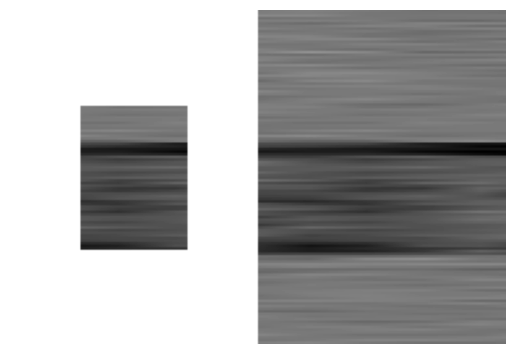

tensor(8), 

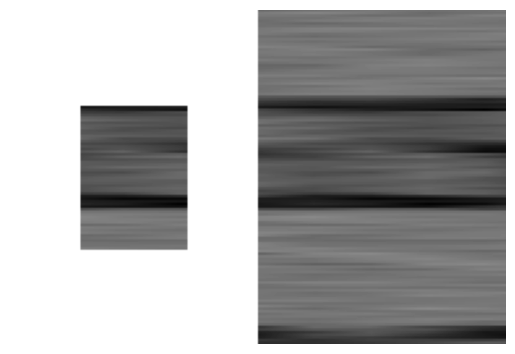

tensor(2), 

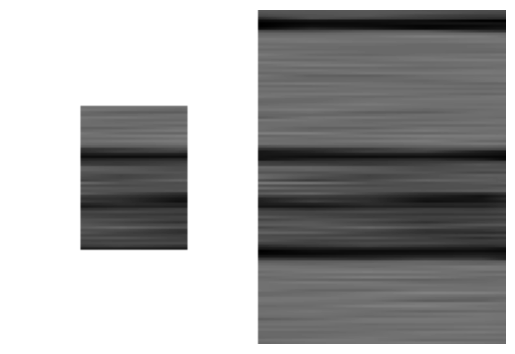

tensor(3), 

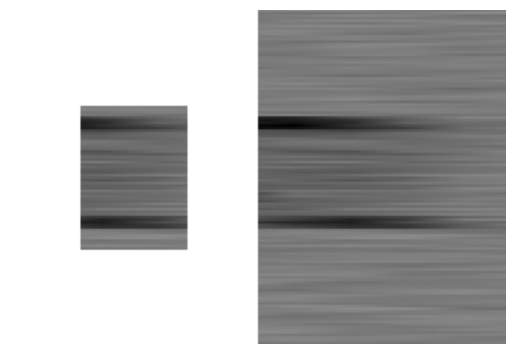

tensor(2), 

In [ ]:
output_dir = os.path.join(ws_dir, 'output/part2')
for idx, i in enumerate([215, 1246, 891, 2024]):
    im = np.concatenate((train_dataset[i][0][0].numpy(), train_dataset[i][0][1].numpy()), axis=1)
    plotgray(im, save_dir=output_dir, file_name=f'input_eg{idx}', axis=False)
    print(train_dataset[i][1], end=', ')

In [ ]:
class MyLeNet(nn.Module):

    def __init__(self):
        super(MyLeNet, self).__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(2, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5)
        # fully connected layers
        self.fc1 = nn.Linear(32 * 12 * 8, 240)  # 12*8 from image dimension
        self.fc2 = nn.Linear(240, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x): # (128, 95)
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # (62, 45)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # (29, 20)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # (12, 8)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

net = MyLeNet().cuda()
print(net)

MyLeNet(
  (conv1): Conv2d(2, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=3072, out_features=240, bias=True)
  (fc2): Linear(in_features=240, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
## Training

criterion = nn.CrossEntropyLoss()

num_epochs = 40
train_losses, test_losses = [], [] # loss for every epoch

optimizer = torch.optim.Adam(net.parameters(), lr=2e-4)
for epoch in range(num_epochs):

    progress_bar = tqdm.tqdm(train_loader)
    running_losses = []

    for i, data in enumerate(progress_bar):
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        # forward pass
        outputs = net(inputs)
        # compute loss
        loss = criterion(outputs, labels)
        # backward pass
        loss.backward()
        # update network parameters
        optimizer.step()
        # save statistics
        running_losses.append(loss.item())
        progress_bar.set_description(f"Loss: {loss}")

    # train loss
    train_losses.append(sum(running_losses)/len(running_losses))
    # validation loss
    with torch.no_grad():
        inputs, labels = next(iter(test_loader))
        outputs = net(inputs.cuda())
        loss = criterion(outputs, labels.cuda())
        test_losses.append(loss.item())

# save the network
output_dir = os.path.join(ws_dir, 'output/part2')
torch.save(net.state_dict(), os.path.join(output_dir, 'checkpoint.pt'))

Loss: 0.08637145906686783: 100%|██████████| 797/797 [00:08<00:00, 98.89it/s] 


In [ ]:
# reload the pre-saved network
output_dir = os.path.join(ws_dir, 'output/part2')
state_dict = torch.load(os.path.join(output_dir, 'checkpoint.pt'))
net.load_state_dict(state_dict)

<All keys matched successfully>

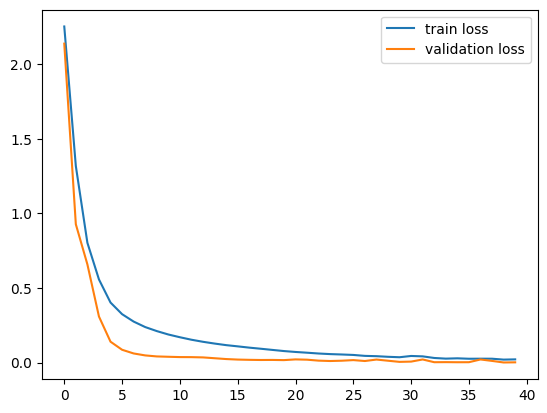

Final train loss: 0.021306143342681192, validation loss: 0.001533345552161336


In [ ]:
plt.figure()
plt.plot(np.arange(num_epochs), train_losses, label='train loss')
plt.plot(np.arange(num_epochs), test_losses, label='validation loss')
plt.legend()
plt.savefig(os.path.join(output_dir, f"loss.jpg"), dpi=500)
plt.show()
print(f"Final train loss: {train_losses[-1]}, validation loss: {test_losses[-1]}")

In [ ]:
## Testing

total, correct = 0, 0
with torch.no_grad():

    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        # calculate outputs by running images through the network
        outputs = net(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predictions = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predictions == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 96 %


100%|██████████| 1/1 [00:00<00:00, 122.36it/s]


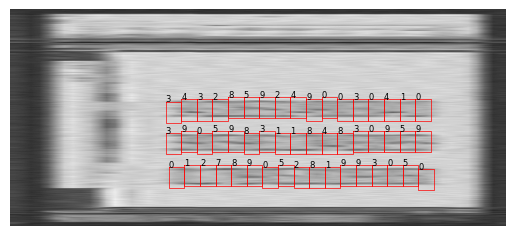

Results:
3 4 3 2 8 5 9 2 4 9 0 0 3 0 4 1 0 
3 9 0 5 9 8 3 1 1 8 4 8 3 0 9 5 9 
0 1 2 7 8 9 0 5 2 8 1 9 9 3 0 5 0 


In [ ]:
## The Whole Workflow: locate and recognize text

class WorkflowDataset(Dataset):

    def __init__(self, image_idx: int):
        assert image_idx >= 50  # make sure it is test image
        input_dir = os.path.join(ws_dir, 'digit_data')
        sorted_items = scan_dir_sorted(input_dir)[:-1]
        file_path = os.path.join(input_dir, sorted_items[image_idx])
        im = sk.img_as_float(skio.imread(file_path))
        im = (rgb2gray(im)-0.5)[:, :, None]
        self.im = im = im.astype('float32')
        self.lx, self.ly = 81, 110
        self.sorted_x, self.sorted_y, self.next_line = [], [], []
        search_dx, search_dy = gridsearch_dataset.dx, gridsearch_dataset.dy

        y = 0.0
        tol = int(0.3*self.ly/search_dy)
        while y < heatmap_bi.shape[0]-tol:
            x = 0
            find_text = False
            while x < heatmap_bi.shape[1]:
                if heatmap_bi[int(y), x]:
                    find_text = True
                    break
                x += 1
            if find_text:
                x = 0.0  # use float to keep accuracy
                while x < heatmap_bi.shape[1]:
                    y_flag = -1
                    for y_ in range(int(y)-tol, int(y)+tol):
                        if heatmap_bi[y_, int(x)]:
                            y_flag = y_
                            break
                    if y_flag != -1:
                        self.sorted_x.append(int(x*search_dx))
                        self.sorted_y.append(int((y_flag+tol/2)*search_dy))
                        x += self.lx/search_dx
                    else:
                        x += 1
                self.next_line.append(len(self.sorted_x))
                y += 1.2*self.ly/search_dy
            else:
                y += 1

    def __len__(self) -> int:
        return len(self.sorted_x)

    def __getitem__(self, idx: int):
        x, y = self.sorted_x[idx], self.sorted_y[idx]
        im = crop_image_with_extended_frame(self.im, x, y)
        im = im.transpose((2, 0, 1))
        return torch.from_numpy(im)

workflow_dataset = WorkflowDataset(image_idx=50)
workflow_loader = DataLoader(workflow_dataset, batch_size=64)

all_predictions = np.array([])
with torch.no_grad():

    progress_bar = tqdm.tqdm(workflow_loader)
    for inputs in progress_bar:
        inputs = inputs.cuda()
        # calculate outputs by running images through the network
        logits = net(inputs)
        probs = F.softmax(logits, 1)
        # the class with the highest energy is what we choose as prediction
        _, predictions = torch.max(probs.data, 1)
        all_predictions = np.concatenate((all_predictions, predictions.cpu().numpy()))

output_dir = os.path.join(ws_dir, 'output/part2')
plt.figure()
plt.imshow(workflow_dataset.im, cmap="gray")
lx, ly = workflow_dataset.lx, workflow_dataset.ly
for i, (x, y) in enumerate(zip(workflow_dataset.sorted_x, workflow_dataset.sorted_y)):
    plt.plot([x, x+lx, x+lx, x, x], [y, y, y+ly, y+ly, y], 'r-', linewidth=0.5)
    plt.text(x, y, int(all_predictions[i]), fontsize=6)
plt.axis(False)
plt.savefig(os.path.join(output_dir, 'result'), dpi=1000)
plt.show()

print('Results:')
pre_l = 0
for l in workflow_dataset.next_line:
    for i in range(pre_l, l):
        print(int(all_predictions[i]), end=' ')
    pre_l = l
    print('')